# Determine how to remove spatial trend (mainly SIF)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.formula.api as smf

from seaborn import pairplot

import fields
import plot
from stat_tools import standardize

In [4]:
%matplotlib inline

## Setup the data

In [5]:
# Get data: 4x5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus_augmented.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

In [58]:
# Analysis variables
month = 8
timedelta = -2
fast_dist = True

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")
timestamp = timestamps[0]

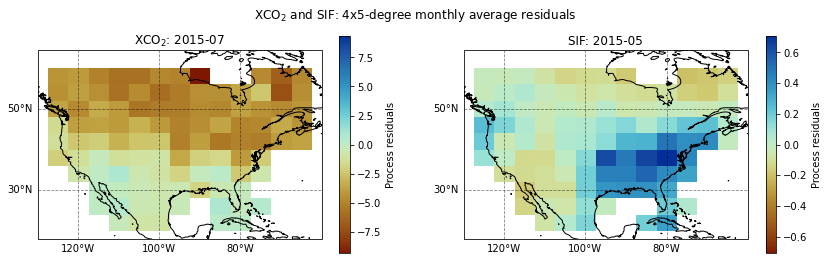

In [59]:
# NOTE: make sure that spatial trend isn't already removed in preprocessing!
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, fast_dist=fast_dist)
plot.plot_fields(mf)

## Fit different surface models for SIF

In [60]:
# format data for statsmodels
f = mf.field_2
df = pd.DataFrame({
    "lat": f.coords[:, 0],
    "lon": f.coords[:, 1],
    "values": f.values
    })
df[["lat", "lon"]] = df[["lat", "lon"]].apply(lambda x: standardize(x), axis=0)
df

lat       lon    values
0     0.877058 -1.718676  0.005031
1     1.227881 -1.718676 -0.015868
2     1.578704 -1.718676 -0.042865
3    -0.175412 -1.691821  0.145883
4     0.175412 -1.691821  0.346588
...        ...       ...       ...
1761  0.175412  1.718676 -0.014491
1762  0.526235  1.718676  0.040289
1763  0.877058  1.718676 -0.019334
1764  1.227881  1.718676 -0.085405
1765  1.578704  1.718676 -0.169359

[1766 rows x 3 columns]

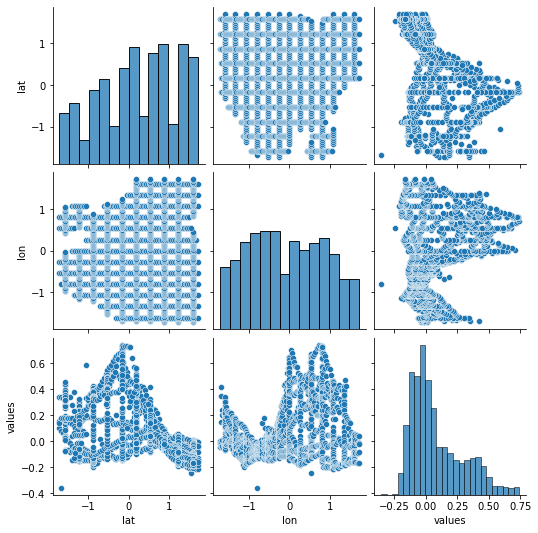

In [61]:
pairplot(df)

In [62]:
res_base = smf.ols(formula='values ~ lat + lon', data=df).fit()
res_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     293.3
Date:                Mon, 09 Aug 2021   Prob (F-statistic):          1.11e-110
Time:                        17:27:00   Log-Likelihood:                 516.50
No. Observations:                1766   AIC:                            -1027.
Df Residuals:                    1763   BIC:                            -1011.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1078      0.004     24.282      0.000       0.099       0.117
lat           -0.0969      0.005    -20.869      0.000      -0.106      -0.088
lon            0.0621      0.005     13.168      0.000       0.053       0.071
==============================================================================
Omnibus:                       97.222   Durbin-Watson:                   0.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.272
Skew:                           0.608   Prob(JB):                     4.17e-25
Kurtosis:                       3.213   Cond. No.                         1.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
res = smf.ols(formula='values ~ lon * lat', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     521.5
Date:                Mon, 09 Aug 2021   Prob (F-statistic):          1.64e-242
Time:                        17:27:00   Log-Likelihood:                 824.02
No. Observations:                1766   AIC:                            -1640.
Df Residuals:                    1762   BIC:                            -1618.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1168      0.004     31.183      0.000       0.109       0.124
lon            0.1218      0.005     26.869      0.000       0.113       0.131
lat           -0.1067      0.004    -27.239      0.000      -0.114      -0.099
lon:lat       -0.1287      0.005    -27.094      0.000      -0.138      -0.119
==============================================================================
Omnibus:                      192.216   Durbin-Watson:                   0.452
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.474
Skew:                           0.700   Prob(JB):                     2.64e-80
Kurtosis:                       4.737   Cond. No.                         1.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
res = smf.ols(formula='values ~ np.power(lat, 2) * np.power(lon, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     156.3
Date:                Mon, 09 Aug 2021   Prob (F-statistic):           7.62e-90
Time:                        17:27:00   Log-Likelihood:                 471.30
No. Observations:                1766   AIC:                            -934.6
Df Residuals:                    1762   BIC:                            -912.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.2216      0.009     23.843      0.000       0.203       0.240
np.power(lat, 2)                     -0.1097      0.007    -14.817      0.000      -0.124      -0.095
np.power(lon, 2)                     -0.0561      0.008     -7.125      0.000      -0.072      -0.041
np.power(lat, 2):np.power(lon, 2)     0.0096      0.006      1.544      0.123      -0.003       0.022
==============================================================================
Omnibus:                      141.667   Durbin-Watson:                   0.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.328
Skew:                           0.767   Prob(JB):                     8.47e-39
Kurtosis:                       2.823   Cond. No.                         6.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
res = smf.ols(formula='values ~ np.power(lat, 3) * np.power(lon, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     148.8
Date:                Mon, 09 Aug 2021   Prob (F-statistic):           5.86e-86
Time:                        17:27:00   Log-Likelihood:                 462.31
No. Observations:                1766   AIC:                            -916.6
Df Residuals:                    1762   BIC:                            -894.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1020      0.005     22.426      0.000       0.093       0.111
np.power(lat, 3)                     -0.0468      0.003    -18.627      0.000      -0.052      -0.042
np.power(lon, 3)                      0.0266      0.003      7.983      0.000       0.020       0.033
np.power(lat, 3):np.power(lon, 3)    -0.0179      0.002    -10.009      0.000      -0.021      -0.014
==============================================================================
Omnibus:                      250.592   Durbin-Watson:                   0.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.438
Skew:                           1.041   Prob(JB):                     2.69e-80
Kurtosis:                       3.806   Cond. No.                         3.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) * np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     445.5
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:01   Log-Likelihood:                 1078.8
No. Observations:                1766   AIC:                            -2144.
Df Residuals:                    1759   BIC:                            -2105.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.2130      0.007     32.277      0.000       0.200       0.226
lon                                   0.1226      0.004     30.886      0.000       0.115       0.130
lat                                  -0.0897      0.004    -24.422      0.000      -0.097      -0.083
lon:lat                              -0.1308      0.004    -31.592      0.000      -0.139      -0.123
np.power(lon, 2)                     -0.0221      0.006     -3.911      0.000      -0.033      -0.011
np.power(lat, 2)                     -0.1020      0.005    -19.382      0.000      -0.112      -0.092
np.power(lon, 2):np.power(lat, 2)     0.0151      0.005      3.346      0.001       0.006       0.024
==============================================================================
Omnibus:                      111.429   Durbin-Watson:                   0.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.023
Skew:                           0.475   Prob(JB):                     3.31e-42
Kurtosis:                       4.302   Cond. No.                         6.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) * np.power(lat, 2) + np.power(lon, 3) * np.power(lat, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     405.7
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:01   Log-Likelihood:                 1256.0
No. Observations:                1766   AIC:                            -2492.
Df Residuals:                    1756   BIC:                            -2437.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.2146      0.006     35.884      0.000       0.203       0.226
lon                                   0.2324      0.007     32.596      0.000       0.218       0.246
lat                                  -0.1214      0.008    -16.049      0.000      -0.136      -0.107
lon:lat                              -0.1480      0.006    -25.641      0.000      -0.159      -0.137
np.power(lon, 2)                     -0.0260      0.005     -4.921      0.000      -0.036      -0.016
np.power(lat, 2)                     -0.0992      0.005    -20.807      0.000      -0.109      -0.090
np.power(lon, 2):np.power(lat, 2)     0.0134      0.004      3.176      0.002       0.005       0.022
np.power(lon, 3)                     -0.0786      0.004    -18.058      0.000      -0.087      -0.070
np.power(lat, 3)                      0.0191      0.004      4.710      0.000       0.011       0.027
np.power(lon, 3):np.power(lat, 3)     0.0167      0.002     10.102      0.000       0.013       0.020
==============================================================================
Omnibus:                      114.388   Durbin-Watson:                   0.641
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.781
Skew:                           0.346   Prob(JB):                     1.08e-66
Kurtosis:                       4.911   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) + np.power(lat, 2) + np.power(lon, 3) + np.power(lat, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     476.1
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:01   Log-Likelihood:                 1201.7
No. Observations:                1766   AIC:                            -2387.
Df Residuals:                    1758   BIC:                            -2344.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2047      0.005     38.558      0.000       0.194       0.215
lon                  0.2227      0.007     30.612      0.000       0.208       0.237
lat                 -0.1241      0.008    -16.083      0.000      -0.139      -0.109
lon:lat             -0.1077      0.004    -25.714      0.000      -0.116      -0.100
np.power(lon, 2)    -0.0140      0.004     -3.677      0.000      -0.021      -0.007
np.power(lat, 2)    -0.0894      0.004    -25.091      0.000      -0.096      -0.082
np.power(lon, 3)    -0.0672      0.004    -15.471      0.000      -0.076      -0.059
np.power(lat, 3)     0.0228      0.004      5.636      0.000       0.015       0.031
==============================================================================
Omnibus:                      100.339   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.130
Skew:                           0.411   Prob(JB):                     3.82e-41
Kurtosis:                       4.361   Cond. No.                         6.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     478.1
Date:                Mon, 09 Aug 2021   Prob (F-statistic):          2.95e-227
Time:                        17:27:01   Log-Likelihood:                 788.79
No. Observations:                1766   AIC:                            -1570.
Df Residuals:                    1762   BIC:                            -1548.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1917      0.005     35.503      0.000       0.181       0.202
lon                  0.1172      0.005     25.399      0.000       0.108       0.126
lon:lat             -0.1234      0.005    -25.535      0.000      -0.133      -0.114
np.power(lat, 2)    -0.1089      0.004    -25.378      0.000      -0.117      -0.100
==============================================================================
Omnibus:                      188.084   Durbin-Watson:                   0.601
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.146
Skew:                           0.898   Prob(JB):                     7.92e-55
Kurtosis:                       3.403   Cond. No.                         2.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2) + lon:np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     365.6
Date:                Mon, 09 Aug 2021   Prob (F-statistic):          2.65e-229
Time:                        17:27:01   Log-Likelihood:                 796.71
No. Observations:                1766   AIC:                            -1583.
Df Residuals:                    1761   BIC:                            -1556.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1924      0.005     35.771      0.000       0.182       0.203
lon                      0.1315      0.006     22.549      0.000       0.120       0.143
lon:lat                 -0.1142      0.005    -21.366      0.000      -0.125      -0.104
np.power(lat, 2)        -0.1098      0.004    -25.666      0.000      -0.118      -0.101
lon:np.power(lat, 2)    -0.0204      0.005     -3.982      0.000      -0.030      -0.010
==============================================================================
Omnibus:                      171.631   Durbin-Watson:                   0.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.943
Skew:                           0.850   Prob(JB):                     6.39e-49
Kurtosis:                       3.351   Cond. No.                         2.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2) + np.power(lon, 2):np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     377.6
Date:                Mon, 09 Aug 2021   Prob (F-statistic):          6.11e-235
Time:                        17:27:01   Log-Likelihood:                 809.74
No. Observations:                1766   AIC:                            -1609.
Df Residuals:                    1761   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1913      0.005     35.835      0.000       0.181       0.202
lon                                   0.1175      0.005     25.753      0.000       0.109       0.126
lon:lat                              -0.1235      0.005    -25.841      0.000      -0.133      -0.114
np.power(lat, 2)                     -0.0891      0.005    -17.073      0.000      -0.099      -0.079
np.power(lon, 2):np.power(lat, 2)    -0.0231      0.004     -6.502      0.000      -0.030      -0.016
==============================================================================
Omnibus:                      155.038   Durbin-Watson:                   0.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.064
Skew:                           0.808   Prob(JB):                     2.66e-43
Kurtosis:                       3.230   Cond. No.                         3.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Selected model

In [72]:
res_sif = smf.ols(formula='values ~ lon * lat + np.power(lat, 2)', data=df).fit()
res_sif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     659.0
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:01   Log-Likelihood:                 1070.8
No. Observations:                1766   AIC:                            -2132.
Df Residuals:                    1761   BIC:                            -2104.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1943      0.005     42.207      0.000       0.185       0.203
lon                  0.1247      0.004     31.613      0.000       0.117       0.132
lat                 -0.0897      0.003    -25.743      0.000      -0.096      -0.083
lon:lat             -0.1323      0.004    -31.989      0.000      -0.140      -0.124
np.power(lat, 2)    -0.0891      0.004    -23.830      0.000      -0.096      -0.082
==============================================================================
Omnibus:                      115.961   Durbin-Watson:                   0.601
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.411
Skew:                           0.449   Prob(JB):                     4.15e-50
Kurtosis:                       4.512   Cond. No.                         2.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
mf.field_2.values = mf.field_2.values - res_sif.predict()

## Fit different surface models for XCO2

In [74]:
# format data for statsmodels
f = mf.field_1
df = pd.DataFrame({
    "lat": f.coords[:, 0],
    "lon": f.coords[:, 1],
    "values": f.values
    })
df[["lat", "lon"]] = df[["lat", "lon"]].apply(lambda x: standardize(x), axis=0)
df

lat       lon    values
0     0.175412 -1.718676  0.081116
1     0.526235 -1.718676 -1.477295
2     0.877058 -1.718676 -4.051697
3     1.227881 -1.718676 -4.402740
4     1.578704 -1.718676 -3.886078
...        ...       ...       ...
1780  1.578704  1.691821 -6.944733
1781  0.175412  1.718676 -2.186035
1782  0.526235  1.718676 -3.694458
1783  0.877058  1.718676 -3.967102
1784  1.578704  1.718676 -4.782166

[1785 rows x 3 columns]

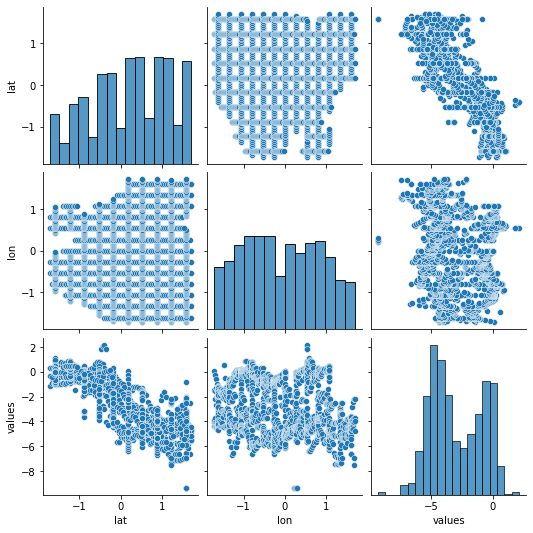

In [75]:
pairplot(df)

In [76]:
res_base = smf.ols(formula='values ~ lat + lon', data=df).fit()
res_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     2360.
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:03   Log-Likelihood:                -2712.0
No. Observations:                1785   AIC:                             5430.
Df Residuals:                    1782   BIC:                             5447.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6019      0.027    -96.452      0.000      -2.655      -2.549
lat           -1.8689      0.028    -66.314      0.000      -1.924      -1.814
lon           -0.4256      0.029    -14.860      0.000      -0.482      -0.369
==============================================================================
Omnibus:                       31.694   Durbin-Watson:                   0.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.338
Skew:                           0.139   Prob(JB):                     4.31e-12
Kurtosis:                       3.792   Cond. No.                         1.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
res = smf.ols(formula='values ~ lat * lon', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     1581.
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:03   Log-Likelihood:                -2708.6
No. Observations:                1785   AIC:                             5425.
Df Residuals:                    1781   BIC:                             5447.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6085      0.027    -96.432      0.000      -2.662      -2.555
lat           -1.8616      0.028    -65.843      0.000      -1.917      -1.806
lon           -0.4657      0.032    -14.371      0.000      -0.529      -0.402
lat:lon        0.0895      0.034      2.627      0.009       0.023       0.156
==============================================================================
Omnibus:                       27.811   Durbin-Watson:                   0.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.509
Skew:                           0.125   Prob(JB):                     2.16e-10
Kurtosis:                       3.732   Cond. No.                         1.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
res = smf.ols(formula='values ~ np.power(lon, 2) + np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     20.87
Date:                Mon, 09 Aug 2021   Prob (F-statistic):           1.09e-09
Time:                        17:27:03   Log-Likelihood:                -3846.5
No. Observations:                1785   AIC:                             7699.
Df Residuals:                    1782   BIC:                             7715.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.4896      0.089    -28.038      0.000      -2.664      -2.315
np.power(lon, 2)    -0.2668      0.061     -4.387      0.000      -0.386      -0.148
np.power(lat, 2)    -0.2757      0.058     -4.794      0.000      -0.389      -0.163
==============================================================================
Omnibus:                      707.498   Durbin-Watson:                   0.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.920
Skew:                           0.171   Prob(JB):                     3.31e-22
Kurtosis:                       1.899   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
res = smf.ols(formula='values ~ lat + lat:lon', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     2033.
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:03   Log-Likelihood:                -2806.5
No. Observations:                1785   AIC:                             5619.
Df Residuals:                    1782   BIC:                             5635.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5602      0.028    -90.319      0.000      -2.616      -2.505
lat           -1.8969      0.030    -63.767      0.000      -1.955      -1.839
lat:lon       -0.1408      0.032     -4.435      0.000      -0.203      -0.079
==============================================================================
Omnibus:                        7.794   Durbin-Watson:                   0.724
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                9.854
Skew:                          -0.031   Prob(JB):                      0.00725
Kurtosis:                       3.359   Cond. No.                         1.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
res = smf.ols(formula='values ~ lat', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     4005.
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:03   Log-Likelihood:                -2816.3
No. Observations:                1785   AIC:                             5637.
Df Residuals:                    1783   BIC:                             5648.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5653      0.028    -90.102      0.000      -2.621      -2.509
lat           -1.8882      0.030    -63.283      0.000      -1.947      -1.830
==============================================================================
Omnibus:                        6.447   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                7.147
Skew:                          -0.081   Prob(JB):                       0.0281
Kurtosis:                       3.265   Cond. No.                         1.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Selected model

In [81]:
res_xco2 = smf.ols(formula='values ~ lon + lat', data=df).fit()
res_xco2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     2360.
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:27:03   Log-Likelihood:                -2712.0
No. Observations:                1785   AIC:                             5430.
Df Residuals:                    1782   BIC:                             5447.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6019      0.027    -96.452      0.000      -2.655      -2.549
lon           -0.4256      0.029    -14.860      0.000      -0.482      -0.369
lat           -1.8689      0.028    -66.314      0.000      -1.924      -1.814
==============================================================================
Omnibus:                       31.694   Durbin-Watson:                   0.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.338
Skew:                           0.139   Prob(JB):                     4.31e-12
Kurtosis:                       3.792   Cond. No.                         1.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
mf.field_1.values = mf.field_1.values - res_xco2.predict()

## Look at the resulting fields

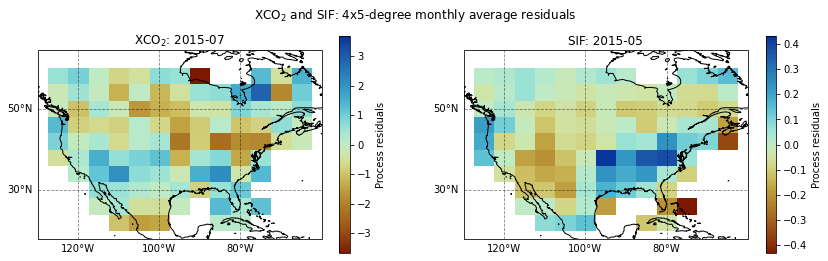

In [83]:
mf.field_1.ds = mf.field_1.to_xarray()
mf.field_2.ds = mf.field_2.to_xarray()
plot.plot_fields(mf)